In [1]:
import cv2
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pickle as pkl

#import pytesseract

#### MLBP (Mean Local Binary Pattern) encoding

In [2]:
# encode the grayscale/binary img
# bw = True if the input img is a binary image (when constructing the database (black-stroke-white-bg) )
# inv = True if we want to encode the inversed image (convert a bright-stroke-dark-bg to dark-stroke-bright-bg)
def encodeImg(img, bw, inv):

    #_, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # assume the background color is the mode of the four edges
    # need 1 pixel as margin
    bg_color = stats.mode( list(img[0,:]) + list(img[-1,:]) + list(img[:,0]) + list(img[:,-1]) )[0][0]
    size = 32

    # if the image is a binary image (when constructing the database)
    # crop to the minimal bounding rect 
    if bw == True:
        blkidx = np.where(img==0)
        if (len(blkidx[0]) != 0):
            img = img[min(blkidx[0]):max(blkidx[0])+1, min(blkidx[1]):max(blkidx[1])+1]

    # resize to (size,size), align in the center, padded with the "background color"
    resize_img = np.zeros((size,size), dtype='uint8') + bg_color
    h, w = img.shape
    # if it is tall and thin
    if h > w:
        scale = size / h
        img = cv2.resize(img, (int(w*scale+0.5), int(h*scale+0.5)) )
        for i in range(int(w*scale)):
            resize_img[:, i+int((size-w*scale)/2) ] = img[:, i]
    # if it is short and fat
    else:
        scale = size / w
        img = cv2.resize(img, (int(w*scale+0.5), int(h*scale+0.5)) )
        for i in range(int(h*scale)):
            resize_img[i+int((size-h*scale)/2), : ] = img[i, :]
    
    img = resize_img
#     plt.figure()
#     plt.imshow(img,"gray")


    # Mean Local Binary Pattern encoding
    img_mlbp = ""

    for i in range(1, size-1):
        for j in range(1, size-1):
            mlbp = ""
            avg = np.mean(img[i-1:i+2, j-1:j+2])
            neighbours = [ (i-1,j-1), (i-1,j), (i-1,j+1), (i,j+1), (i+1,j+1), (i+1,j), (i+1,j-1), (i,j-1) ]
            for idx in neighbours:
                
                if inv == False:
                    if img[idx] > avg:    mlbp += "1"
                    else:                 mlbp += "0"
                else: # inv == True:
                    if img[idx] < avg:    mlbp += "1"
                    else:                 mlbp += "0"
            
            img_mlbp += mlbp
            
    return img_mlbp


# return the similarity score of (a_mlbp, b_mlbp), [0,1], 1 -> same
def compareMlbp(a_mlbp, b_mlbp):
    
    if a_mlbp == None or b_mlbp == None:
#         print('None')
        return float('Inf')
    if len(a_mlbp) != len(b_mlbp):
#         print("len does not match")
        return float('Inf')
    
    dist = 0
    for i in range(len(a_mlbp)):
#         dist += int(a_mlbp[i]) - int(b_mlbp[i])
        if a_mlbp[i] != b_mlbp[i]:
            dist+=1
    return 1 - dist/len(a_mlbp)

#### Step0: Prepare the dataset

In [3]:
# ### prepare the mlbp dataset

# import string
# letters = list(string.ascii_uppercase) + list(string.ascii_lowercase)
# mlbp_dict = {}

# font = 'lettersTimesNewRoman/'
# #font = 'lettersHelveticaNeue/'

# for i in range(26):   
#     img = cv2.imread(font + letters[i] + '.png')
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     mlbp_dict[string.ascii_uppercase[i]] = encodeImg(gray, True, False)
# for i in range(26):    
#     img = cv2.imread(font + letters[i+26]*2 + '.png')
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     mlbp_dict[string.ascii_lowercase[i]] = encodeImg(gray, True, False)
    
# filepath = 'mlbp_dict.pkl'
# f = open(filepath,'wb')
# pkl.dump(mlbp_dict,f)
# f.close()
# print ('"mlbp_dict.pkl" has been written')

In [4]:
filepath = 'mlbp_dict.pkl'
f = open(filepath, 'rb')  # The 'rb' is for openning file to be read in binary mode
mlbp_dict = pkl.load(f)
f.close()
print ('loaded from "mlbp_dict.pkl"')

loaded from "mlbp_dict.pkl"


#### Load the image and Determine the parameters

In [5]:
img = cv2.imread('text1.jpg') # 1,2,4,(5,6,7)
# cv2.imshow('orig', img)
# cv2.waitKey(0)

HEIGHT, WIDTH, _ = img.shape

# region edge
EDGE_MIN = min(HEIGHT, WIDTH) / 60
EDGE_MAX = max(HEIGHT, WIDTH) * 0.8

# region area
AREA_MIN = HEIGHT*WIDTH / 2000
AREA_MAX = HEIGHT*WIDTH * 0.2

# aspect ratio
AR_MIN = 0.3
AR_MAX = 1.5

#### Step1-2 MSER

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    #Convert to gray scale
_, bw = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


#Create MSER object
mser = cv2.MSER_create()
#detect regions in gray scale image
regions, _ = mser.detectRegions(gray)
print("Number of MSER regions:", len(regions))

vis1 = img.copy()    # output
for region in regions:
    x, y, w, h = cv2.boundingRect(region)
    cv2.rectangle(vis1, (x, y), (x+w-1, y+h-1), (0, 255, 0), 2)


Number of MSER regions: 824


#### Step 2.5 cleaning MSER

In [7]:
# return True if rect1 covers rect2
def cover(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    if x1 <= x2 and x1+w1 >= x2+w2 and y1 <= y2 and y1+h1 >= y2+h2:
        return True
    else:
        return False

# return True if rect is a maximal rect in rects
def isMaximal(rect, rects):
    for other in rects:
        if other != rect and cover(other, rect):
            return False
    return True

In [8]:
vis2 = img.copy()    # output

# eliminate the whole black/white
###############STD_MIN = 20

rects = []
for region in regions:
    x, y, w, h = cv2.boundingRect(region)

    # aspect ratio and size
    if min(w,h) < EDGE_MAX and max(w,h) > EDGE_MIN and w*h < AREA_MAX and w*h > AREA_MIN and w/h < AR_MAX and w/h > AR_MIN:
    #if min(w,h) < EDGE_MAX and min(w,h) > EDGE_MIN and w*h < AREA_MAX and w*h > AREA_MIN and w/h < AR_MAX and w/h > AR_MIN:
        #print(np.std(bw[x:x+w,y:y+h]))
        #if np.std(bw[x:x+w,y:y+h]) > STD_MIN or np.std(bw[x:x+w,y:y+h])==np.nan:
            if (x, y, w, h) not in rects:
                rects.append((x, y, w, h))

real_rects = []
for rect in rects:
    if isMaximal(rect, rects):
        real_rects.append(rect)
        x, y, w, h = rect
        cv2.rectangle(vis2, (x, y), (x+w+1, y+h+1), (0, 255, 0), 2)
        
rects = real_rects
print("Number of text candidates:", len(rects))

Number of text candidates: 57


Number of MSER regions: 824
Number of text candidates: 57


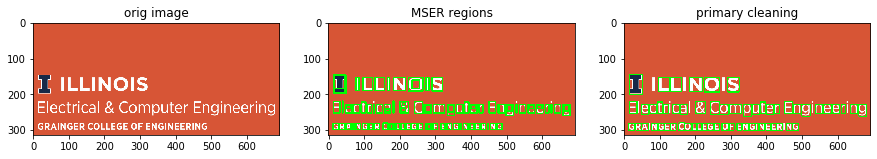

In [9]:
plt.figure(figsize=(15,9))
plt.subplot(131)
plt.title('orig image')
plt.imshow(img[:,:,::-1])

plt.subplot(132)
plt.title("MSER regions")
plt.imshow(vis1[:,:,::-1])

plt.subplot(133)
plt.title("primary cleaning")
plt.imshow(vis2[:,:,::-1])

print("Number of MSER regions:", len(regions))
print("Number of text candidates:", len(rects))

#### Step 3: double treshold classifier

In [10]:
# roi - gray image
# return the min dist value and the nearest letter
def cannyTextClassifier(roi, mlbp_dict):
    
    #_, roi = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    roi_mlbp = encodeImg(roi, True, False)
    inv_roi_mlbp = encodeImg(roi, True, True)
    
    maxsim = -float('Inf')
    key = ''
    
    #exempt_list = ['l', 'J', 'I', 'j', 'i']
    exempt_list = []
    
    for k,v in mlbp_dict.items():
        sim = max( compareMlbp(roi_mlbp, v), compareMlbp(inv_roi_mlbp, v) )
        if sim > maxsim and (k not in exempt_list):
            maxsim = sim
            key = k
    
    return maxsim, key

In [11]:
th1 = 0.75
th2 = 0.45

tth1 = 0.88
tth2 = 0.60

lth1 = 0.85
lth2 = 0.60

strong_text = []
weak_text = []
non_text = []

for rect in rects:
    x, y, w, h = rect
    roi = bw[y:y+h, x:x+w]
    sim, letter = cannyTextClassifier(roi, mlbp_dict)
    

    # need to prone some confusing background

    # impossible to get "i" and "j" because they has two parts
    if letter != 'i' and letter != 'j':
        #print(letter)
        
        # "t" and "l" has the most false positive
        if letter == "t":
            if sim > tth1:
                strong_text.append(rect)
            elif sim > tth2:
                weak_text.append(rect)
            else:
                non_text.append(rect)
        
        elif letter == "l":
            if sim > tth1:
                strong_text.append(rect)
            elif sim > tth2:
                weak_text.append(rect)
            else:
                non_text.append(rect)
        
        
        elif sim > th1:
            strong_text.append(rect)
        elif sim > th2:
            weak_text.append(rect)
        else:
            non_text.append(rect)
        

vis3 = img.copy()
for text in strong_text:
    x, y, w, h = text
    cv2.rectangle(vis3, (x, y), (x+w-1, y+h-1), (0, 255, 0), 2)

for text in weak_text:
    x, y, w, h = text
    cv2.rectangle(vis3, (x, y), (x+w-1, y+h-1), (0, 0, 255), 2)
    
print("Number of strong text:", len(strong_text))
print("Number of weak text:", len(weak_text))

strong_copy = strong_text.copy() # DEBUG
weak_copy = weak_text.copy() # DEBUG

Number of strong text: 18
Number of weak text: 31


In [12]:
# vistmp = img.copy()
# x, y, w, h = (247, 280, 18, 18)
# cv2.rectangle(vistmp, (x, y), (x+w-1, y+h-1), (0, 255, 0), 2)
    
# plt.figure()
# plt.title("tmp")
# plt.imshow(vistmp[:,:,::-1])

# roi = bw[y:y+h+1, x:x+w+1]
# plt.figure()
# plt.imshow(roi, "gray")
# print(cannyTextClassifier(roi, mlbp_dict))

Number of strong text: 18
Number of weak text: 31


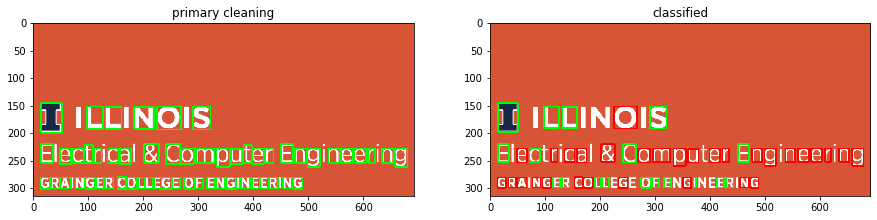

In [13]:
plt.figure(figsize=(15,9))

plt.subplot(121)
plt.title("primary cleaning")
plt.imshow(vis2[:,:,::-1])

plt.subplot(122)
plt.title("classified")
plt.imshow(vis3[:,:,::-1])

print("Number of strong text:", len(strong_text))
print("Number of weak text:", len(weak_text))

In [14]:
# # DEBUG: find the index of rect to see what the hell is going on...
# # @param: xlim - (lb, ub); ylim - (lb, ub); rects - list of rect
# # @return: a list of index in rect
# def find_rect_idx(xlim, ylim, rects):
#     ret = []
#     for idx in range(len(rects)):
#         i = rects[idx]
#         if i[0] >= xlim[0] and i[0] <= xlim[1] and i[1] >= ylim[0] and i[1] <= ylim[1]:
#             ret.append(idx)
#     return ret

# all_text = strong_copy + weak_copy
# find_rect_idx((50, 100), (50,100), all_text)

In [15]:
# x, y, w, h = all_text[1]
# roi = bw[y:y+h, x:x+w]
# print(cannyTextClassifier(roi, mlbp_dict))

# vistmp = img.copy()
# for text in [all_text[1]]:
#     x, y, w, h = text
#     cv2.rectangle(vistmp, (x, y), (x+w-1, y+h-1), (0, 255, 0), 2)
    
# plt.figure()
# plt.title("tmp")
# plt.imshow(vistmp[:,:,::-1])

#### Step 4: Hysteresis tracking

In [16]:
ALIGN_RATIO = 0.2
H_SPACE_RATIO = 0.85
V_SPACE_RATIO = 0.05

def close(a, b):
    (xa, ya, wa, ha) = a
    (xb, yb, wb, hb) = b
    
    # horizontal grouping
    # a and b should be in the same line
    if yb <= ya + ha - hb*ALIGN_RATIO and yb + hb >= ya + hb*ALIGN_RATIO:
        # allow a space
        if ( (xb <= xa + wa + wb*H_SPACE_RATIO and xb >= xa + wa - wb*H_SPACE_RATIO ) or 
             (xb + wb >= xa - wb*H_SPACE_RATIO and xb + wb <= xa + wb*H_SPACE_RATIO) ):
            return True
        
    # vertical grouping
    # a and b should be in the same line
    if xb <= xa + wa + wb*ALIGN_RATIO and xb + wb >= xa - wb*ALIGN_RATIO:
        # allow a space
        if ( (yb <= ya + ha + hb*V_SPACE_RATIO and yb >= ya + ha - hb*V_SPACE_RATIO ) or 
             (yb + hb >= ya - hb*V_SPACE_RATIO and yb + hb <= ya + hb*V_SPACE_RATIO) ):
            return True
    
    return False

In [17]:
strong_text = strong_copy.copy() # DEBUG

texts = []
texts.extend(strong_text)

while len(strong_text) != 0 :
    
    atext = strong_text[0]
    
    for weak in weak_text:
        if weak not in texts and close(atext, weak):
            texts.append(weak)
            strong_text.append(weak)
    del strong_text[0]


vis4 = img.copy()
for text in texts:
    x, y, w, h = text
    cv2.rectangle(vis4, (x, y), (x+w-1, y+h-1), (0, 255, 0), 2)
    
print("Number of texts:", len(texts))

Number of texts: 43


Number of strong text: 11
Number of weak text: 13
Number of text after hysteresis tracking: 43


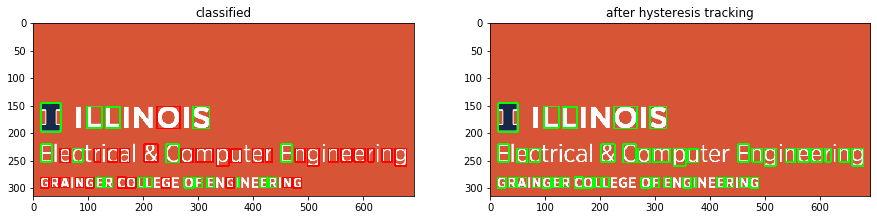

In [18]:
plt.figure(figsize=(15,9))
plt.subplot(121)
plt.title("classified")
plt.imshow(vis3[:,:,::-1])

plt.subplot(122)
plt.title("after hysteresis tracking")
plt.imshow(vis4[:,:,::-1])

print("Number of strong text: 11") # 11
print("Number of weak text: 13") # 13
print("Number of text after hysteresis tracking:", len(texts))

#### Step5: grouping

In [19]:
# return index in [text]
def find_merge_idx(a, text):
    for idx in range(len(text)):
        if text[idx] != a and close(a, text[idx]):
            return idx
    return -1


def merge_rect(a, b):
    (xa, ya, wa, ha) = a
    (xb, yb, wb, hb) = b
    x = min(xa, xb)
    y = min(ya, yb)
    w = max(xa+wa, xb+wb) - x
    h = max(ya+ha, yb+hb) - y
    return (x, y, w, h)

In [20]:
texts = sorted(texts, key=lambda x: (x[1],x[0]), reverse=False)
count = 0
while True:
    count+=1

    # do all possible merge for text[0]
    while True:
        merge_idx = find_merge_idx(texts[0], texts)
        if merge_idx == -1:
            break
        
        # update the list
        merge = merge_rect(texts[0], texts[merge_idx])
        texts[0] = merge
        del texts[merge_idx]
    
    # move the maximal text to the tail
    texts.append(texts[0])
    del texts[0]

    # check stopping condition
    stop = 1
    for t in texts:
        if find_merge_idx(t, texts) != -1:
            stop = 0
            break
    
    # nothing more can be done
    if stop == 1:
        break

    
vis5 = img.copy()
for i in texts:
    x, y, w, h = i
    cv2.rectangle(vis5, (x, y), (x+w-1, y+h-1), (0, 255, 0), 2)

Number of strong text: 11
Number of weak text: 13
Number of text after hysteresis tracking: 17


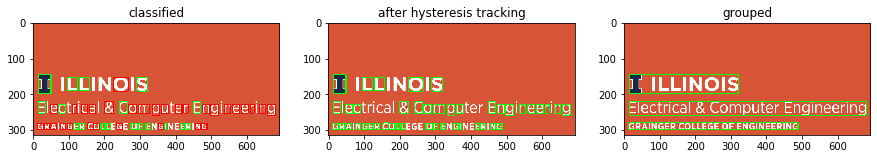

In [21]:
plt.figure(figsize=(15,9))
plt.subplot(131)
plt.title("classified")
plt.imshow(vis3[:,:,::-1])

plt.subplot(132)
plt.title("after hysteresis tracking")
plt.imshow(vis4[:,:,::-1])

plt.subplot(133)
plt.title("grouped")
plt.imshow(vis5[:,:,::-1])

print("Number of strong text: 11")
print("Number of weak text: 13")
print("Number of text after hysteresis tracking: 17")

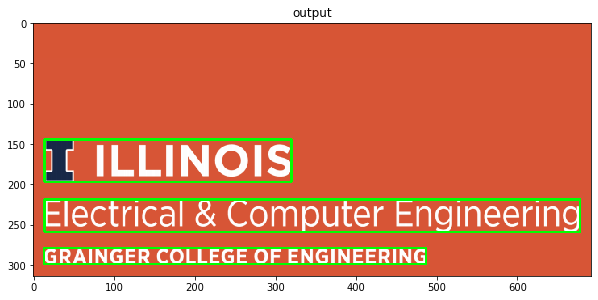

In [22]:
plt.figure(figsize=(10,6))
plt.title("output")
plt.imshow(vis5[:,:,::-1])

In [23]:
# weak_reduced = []

# #print(strong_text[11])
# #print(img[strong_text[11][0]:strong_text[11][0]+strong_text[11][2],strong_text[11][1]:strong_text[11][1]+strong_text[1][3],::-1])
# #for weak in weak_text:
# #    if weak[0]+weak[2] > WIDTH or weak[1]+weak[3] > HEIGHT:
# #        weak_text.remove(weak)
# #        
# #for strong in strong_text:
# #    if strong[0]+strong[2] > WIDTH or strong[1]+strong[3] > HEIGHT:
# #        strong_text.remove(strong)
# #            
# #print(len(weak_text))
# #print(len(strong_text))
# for weak in weak_text:
#     x, y, w, h = weak
#     weak_hyt = np.mean(bw[y:y+h,x:x+w]) 
    
#     #print("weak")
#     #print(weak_hyt)
#     #print("\n")
#     for strong in strong_text:
        
#         x, y, w, h = strong
#         strong_hyt = np.mean(bw[y:y+h,x:x+w]) 
        
#         #print("strong")
#         #print(strong_hyt)
#         #print("\n")
#         #print(np.abs(weak_hyt-strong_hyt)*100 //((strong_hyt+weak_hyt)//2))
#         if (np.abs(weak_hyt-strong_hyt)*100 //((strong_hyt+weak_hyt)//2) < 25
        
#             #make sure it is close to strong image
#             and
#             (np.abs(weak[0]-strong[0]) <= WIDTH*.1 or
#             np.abs(weak[0]-(strong[0]+strong[2])) <= WIDTH*.1 or
#             np.abs(weak[0]+weak[2]-strong[0]) <= WIDTH*.1 or
#             np.abs(weak[0]+weak[2]-(strong[0]+strong[2])) <= WIDTH*.1) and 
            
#             #make sure it is close to size of a strong image
#             np.abs(weak[2]-strong[2]) <= WIDTH*.1 and
#             np.abs(weak[3]-strong[3]) <= HEIGHT*.1):
            
#             weak_reduced.append(weak)
#             break
            
        
# print(len(weak_reduced))
# print(len(strong_text))
# vis_temp = img.copy()

# for text in strong_text:
#     x, y, w, h = text
#     cv2.rectangle(vis_temp, (x, y), (x+w-1, y+h-1), (0, 255, 0), 2)

# for text in weak_reduced:
#     x, y, w, h = text
#     cv2.rectangle(vis_temp, (x, y), (x+w-1, y+h-1), (0, 0, 255), 2)
    
# plt.figure()
# plt.title("hys")
# plt.imshow(vis_temp[:,:,::-1])

In [24]:
# # Load HSV format, define lower/upper ranges, and perform color segmentation to create a binary mask
# hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# lower = np.array([0, 0, 218])
# upper = np.array([157, 54, 255])
# mask = cv2.inRange(hsv, lower, upper)

# # Create horizontal kernel and dilate to connect text characters
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,3))
# dilate = cv2.dilate(mask, kernel, iterations=7)

# # Find contours and filter using aspect ratio
# # Remove non-text contours by filling in the contour
# contours = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# contours = contours[0] if len(contours) == 2 else contours[1]

# vis3 = img.copy()
# for c in contours:
#     x, y, w, h = cv2.boundingRect(c)
#     cv2.rectangle(vis3, (x, y), (x+w-1, y+h-1), (0, 255, 0), 2)

# plt.figure()
# plt.imshow(vis3[:,:,::-1])

# for c in contours:
#     x,y,w,h = cv2.boundingRect(c)
#     ar = w / float(h)
#     if ar < 5:
#         cv2.drawContours(dilate, [c], -1, (0,0,0), -1)


# # Bitwise dilated image with mask, invert, then OCR
# result = 255 - cv2.bitwise_and(dilate, mask)
# plt.figure()
# plt.imshow(result, "gray")

In [25]:
# edges = cv2.Canny(img,100,200)
# plt.figure()
# plt.imshow(edges, 'gray')

In [26]:
# # mask out the text
# text_only = cv2.bitwise_and(img, img, mask=mask)
# plt.figure()
# plt.imshow(text_only[:,:,::-1])
# # cv2.imshow("text only", text_only)
# # cv2.waitKey(0)

In [27]:

# large = cv2.imread('text3.png')
# rgb = cv2.pyrDown(large)
# small = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
# grad = cv2.morphologyEx(small, cv2.MORPH_GRADIENT, kernel)

# _, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))
# connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)
# # using RETR_EXTERNAL instead of RETR_CCOMP
# contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# #For opencv 3+ comment the previous line and uncomment the following line
# #_, contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# mask = np.zeros(bw.shape, dtype=np.uint8)

# for idx in range(len(contours)):
#     x, y, w, h = cv2.boundingRect(contours[idx])
#     mask[y:y+h, x:x+w] = 0
#     cv2.drawContours(mask, contours, idx, (255, 255, 255), -1)
#     r = float(cv2.countNonZero(mask[y:y+h, x:x+w])) / (w * h)

#     if r > 0.45 and w > 8 and h > 8:
#         cv2.rectangle(rgb, (x, y), (x+w-1, y+h-1), (0, 255, 0), 2)

# plt.figure()
# plt.imshow(rgb)